# Using `astropy.coordinates` to Match Catalogs and Plan Observations

In this tutorial, we will explore how the `astropy.coordinates` package and related astropy functionality can be used to help in planning observations or other exercises focused on large coordinate catalogs.

In [1]:
# Python standard-library
from urllib.parse import urlencode
from urllib.request import urlretrieve

# Third-party dependencies
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
import numpy as np
from IPython.display import Image

In [2]:
# Set up matplotlib and use a nicer set of plot parameters
import matplotlib.pyplot as plt
%matplotlib inline

## Describing on-sky locations with `coordinates`

Let's start by considering a field around the picturesque Hickson Compact Group 7.  To do anything with this, we need to get an object that represents the coordinates of the center of this group.

In Astropy, the most common object you'll work with for coordinates is `SkyCoord`.  A `SkyCoord` can be created most easily directly from angles as shown below.  It's also wise to explicitly specify the frame your coordinates are in, although this is not strictly necessary because the default is ICRS. 

(If you're not sure what ICRS is, it's basically safe to think of it as an approximation to an equatorial system at the J2000 equinox).

In [3]:
hcg7_center = SkyCoord(9.81625*u.deg, 0.88806*u.deg, frame='icrs')
hcg7_center

<SkyCoord (ICRS): (ra, dec) in deg
    (9.81625, 0.88806)>

SkyCoord will also accept string-formatted coordinates either as separate strings for ra/dec or a single string.  You'll have to give units, though, if they aren't part of the string itself.

In [4]:
SkyCoord('0h39m15.9s', '0d53m17.016s', frame='icrs')

<SkyCoord (ICRS): (ra, dec) in deg
    (9.81625, 0.88806)>

In [5]:
SkyCoord('0:39:15.9 0:53:17.016', unit=(u.hour, u.deg), frame='icrs')

<SkyCoord (ICRS): (ra, dec) in deg
    (9.81625, 0.88806)>

If the object you're interested in is in [SESAME](http://cdsweb.u-strasbg.fr/cgi-bin/Sesame), you can also look it up directly from its name using the `SkyCoord.from_name()` class method<sup>1</sup>. Note that this requires an internet connection.  It's safe to skip if you don't have one, because we defined it above explicitly.

*If you don't know what a class method is, think of it like an alternative constructor for a `SkyCoord` object -- calling `SkyCoord.from_name()` with a name gives you a new `SkyCoord` object. For more detailed background on what class methods are and when they're useful, see [this page](https://julien.danjou.info/blog/2013/guide-python-static-class-abstract-methods).*

In [6]:
hcg7_center = SkyCoord.from_name('HCG 7')
hcg7_center

<SkyCoord (ICRS): (ra, dec) in deg
    (9.81625, 0.88806)>

This object we just created has various useful ways of accessing the information contained within it.  In particular, the ``ra`` and ``dec`` attributes are specialized [``Quantity``](http://docs.astropy.org/en/stable/units/index.html) objects (actually, a subclass called [``Angle``](http://docs.astropy.org/en/stable/api/astropy.coordinates.Angle.html), which in turn is subclassed by [``Latitude``](http://docs.astropy.org/en/stable/api/astropy.coordinates.Latitude.html) and [``Longitude``](http://docs.astropy.org/en/stable/api/astropy.coordinates.Longitude.html)).  These objects store angles and provide pretty representations of those angles, as well as some useful attributes to quickly convert to common angle units:

In [7]:
type(hcg7_center.ra), type(hcg7_center.dec)

(astropy.coordinates.angles.Longitude, astropy.coordinates.angles.Latitude)

In [8]:
hcg7_center.dec

<Latitude 0.88806 deg>

In [9]:
hcg7_center.ra

<Longitude 9.81625 deg>

In [10]:
hcg7_center.ra.hour

0.6544166666666668

Now that we have a `SkyCoord` object, we can try to use it to access data from the [Sloan Digitial Sky Survey](http://www.sdss.org/) (SDSS).  Let's start by trying to get a picture using the SDSS image cutout service to make sure HCG7 is in the SDSS footprint and has good image quality.

This requires an internet connection, but if it fails, don't worry: the file is included in the repository so you can just let it use the local file``'HCG7_SDSS_cutout.jpg'``, defined at the top of the cell.  

In [11]:
impix = 1024
imsize = 12*u.arcmin
cutoutbaseurl = 'http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
query_string = urlencode(dict(ra=hcg7_center.ra.deg, 
                              dec=hcg7_center.dec.deg, 
                              width=impix, height=impix, 
                              scale=imsize.to(u.arcsec).value/impix))
url = cutoutbaseurl + '?' + query_string

# this downloads the image to your disk
urlretrieve(url, 'HCG7_SDSS_cutout.jpg')

('HCG7_SDSS_cutout.jpg', <http.client.HTTPMessage at 0x7f4c0c05e7f0>)

Now lets take a look at the image.

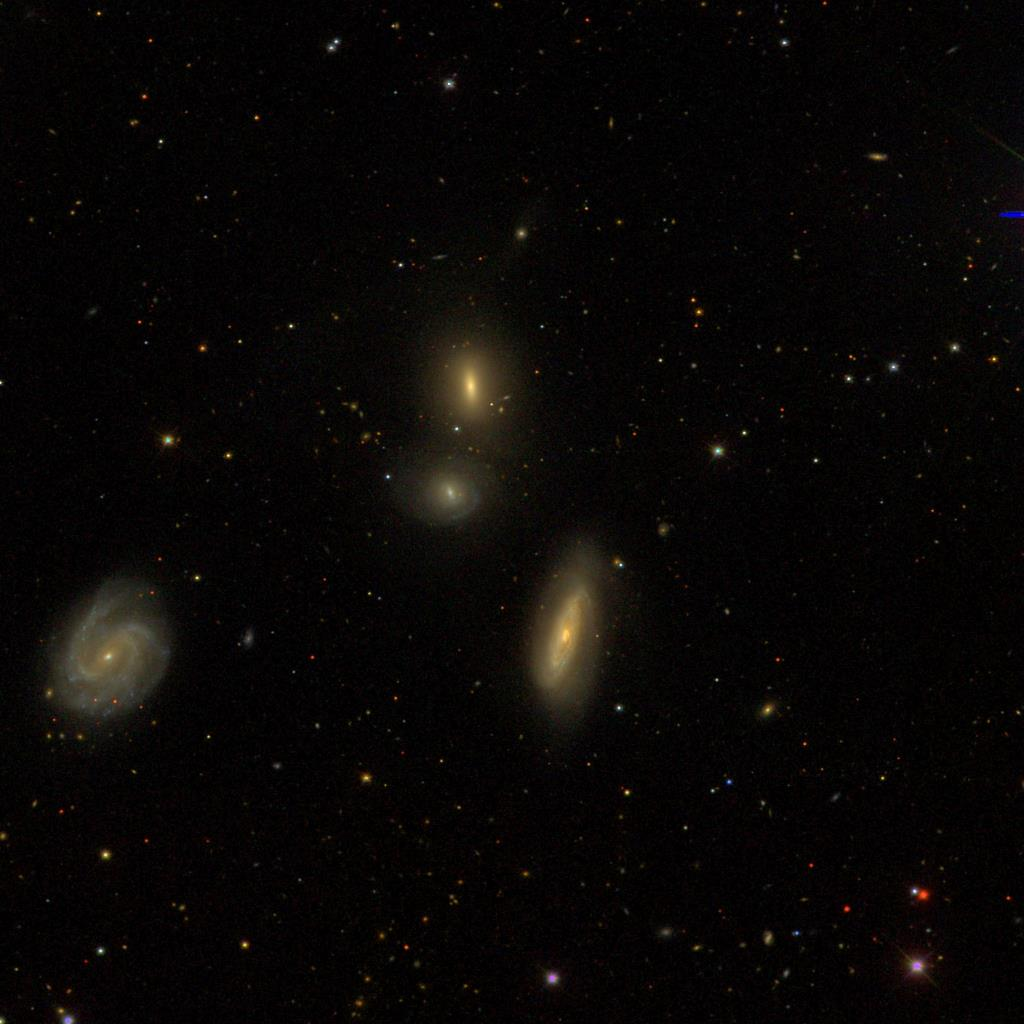

In [12]:
Image('HCG7_SDSS_cutout.jpg')

Very pretty!

### Exercises

Create a `SkyCoord` of some other astronomical object you find interesting. Using only a single method/function call, get a string with the RA/Dec in the form 'HH:MM:SS.S DD:MM:SS.S'.  Check your answer against an academic paper or some web site like [SIMBAD](http://simbad.u-strasbg.fr/simbad/) that will show you sexigesimal coordinates for the object.

(Hint: `SkyCoord.to_string()` might be worth reading up on)

Now get an image of that object from the Digitized Sky Survey and download it and/or show it in the notebook. Bonus points if you figure out the (one-line) trick to get it to display in the notebook *without* ever downloading the file yourself.

(Hint: STScI has an easy-to-access [copy of the DSS](https://archive.stsci.edu/dss/).  The pattern to follow for the web URL is ``http://archive.stsci.edu/cgi-bin/dss_search?f=GIF&ra=RA&dec=DEC``)

## Using `coordinates` and `table` to match and compare catalogs

At the end of the last section, we determined that HCG7 is in the SDSS imaging survey, so that means we can use the cells below to download catalogs of objects directly from the SDSS. Later on, we will match this catalog to another catalog covering the same field, allowing us to make plots using the combination of the two catalogs.

We will access the SDSS SQL database using the [astroquery](https://astroquery.readthedocs.org) affiliated package.  This will require an internet connection and a working install of astroquery. If you don't have these you can just skip down two cells, because the data files are provided with the repository. Depending on your version of astroquery it might also issue a warning, which you should be able to safely ignore.

In [13]:
from astroquery.sdss import SDSS
sdss = SDSS.query_region(coordinates=hcg7_center, radius=20*u.arcmin, 
                         spectro=True, 
                         photoobj_fields=['ra','dec','u','g','r','i','z'])

/home/circleci/project/venv/lib/python3.6/site-packages/astroquery/sdss/__init__.py:29: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


`astroquery` queries gives us back an [`astropy.table.Table` object](http://docs.astropy.org/en/stable/table/index.html).  We could just work with this directly without saving anything to disk if we wanted to.  But here we will use the capability to  write to disk.  That way, if you quit the session and come back later, you don't have to run the query a second time.

(Note that this won't work fail if you skipped the last step.  Don't worry, you can just skip to the next cell with ``Table.read`` and use the copy of this table included in the tutorial.)

In [14]:
sdss.write('HCG7_SDSS_photo.dat', format='ascii')

If you don't have internet, you can read the table into python by running the cell below.  But if you did the astroquery step above, you could skip this, as the table is already in memory as the `sdss` variable.

In [15]:
sdss = Table.read('HCG7_SDSS_photo.dat', format='ascii')

Ok, so we have a catalog of objects we got from the SDSS.  Now lets say you have your own catalog of objects in the same field that you want to match to this SDSS catalog.  In this case, we will use a catalog extracted from the [2MASS](http://www.ipac.caltech.edu/2mass/).  We first load up this catalog into python.

In [16]:
twomass = Table.read('HCG7_2MASS.tbl', format='ascii')

Now to do matching we need `SkyCoord` objects.  We'll have to build these from the tables we loaded, but it turns out that's pretty straightforward: we grab the RA and dec columns from the table and provide them to the `SkyCoord` constructor.  Lets first have a look at the tables to see just what everything is that's in them.

In [17]:
sdss # just to see an example of the format

ra,dec,u,g,r,i,z
float64,float64,float64,float64,float64,float64,float64
9.79537845566955,0.849932759023708,18.19011,16.74625,16.20456,16.02315,15.95449
9.91404352649283,1.10767806592904,23.92247,23.17045,21.37167,20.181,19.5382
10.0560787779458,0.591223414459663,22.60917,21.96171,22.08046,21.68144,21.89079
9.71431790060433,1.04953522552351,21.61689,19.42595,18.4278,18.10297,17.92925
10.0298203018955,0.785404231428639,20.93396,19.98706,19.61393,19.46158,19.38252
10.001921893077,0.956962974170162,22.36868,19.51999,18.16483,17.41288,16.98804
9.77189392633511,1.08851778782272,22.1365,19.42289,18.11884,17.5613,17.25852
9.97504216856794,0.960430039213302,21.2758,20.61082,20.37434,19.8638,19.55642
10.1283614953755,1.20359549821362,18.65038,17.38721,16.93356,16.68318,16.53578


In [18]:
twomass # just to see an example of the format

designation,ra,dec,r_k20fe,j_m_k20fe,j_msig_k20fe,j_flg_k20fe,h_m_k20fe,h_msig_k20fe,h_flg_k20fe,k_m_k20fe,k_msig_k20fe,k_flg_k20fe,k_ba,k_phi,sup_ba,sup_phi,r_ext,j_m_ext,j_msig_ext,h_m_ext,h_msig_ext,k_m_ext,k_msig_ext,cc_flg,dist,angle
,deg,deg,arcsec,mag,mag,,mag,mag,,mag,mag,,,deg,,deg,arcsec,mag,mag,mag,mag,mag,mag,,arcsec,deg
str16,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,str1,float64,float64
00402069+0052508,10.086218,0.880798,9.4,13.835,0.068,0,13.01,0.086,0,12.588,0.089,0,0.8,70,0.82,35,18.62,13.632,0.088,12.744,0.104,12.398,0.105,0,972.120611,91.538952
00395984+0103545,9.99935,1.06514,12.9,12.925,0.035,0,12.183,0.042,0,11.89,0.067,0,0.8,35,0.7,40,35.9,12.469,0.048,11.91,0.066,11.522,0.087,0,916.927636,45.951861
00401849+0049448,10.077062,0.82913,6.0,14.918,0.086,0,14.113,0.107,0,13.714,0.103,0,0.6,-15,1.0,90,11.35,14.631,0.121,13.953,0.169,13.525,0.161,0,962.489231,102.73149
00395277+0057124,9.969907,0.953472,5.3,14.702,0.049,0,14.248,0.069,0,13.899,0.095,0,0.6,-60,0.44,-50,10.59,14.62,0.144,14.15,0.296,13.73,0.2,0,601.136444,66.93659
00401864+0047245,10.077704,0.790143,7.6,15.585,0.134,1,15.003,0.18,1,14.049,0.142,1,0.5,30,0.46,30,14.48,14.977,0.138,14.855,0.303,13.653,0.18,0,1004.982128,110.53147
00393485+0051355,9.895219,0.859882,39.3,11.415,0.031,3,10.755,0.044,3,10.514,0.068,3,0.6,-30,0.7,-60,92.29,11.415,0.018,10.155,0.054,9.976,0.085,0,301.813395,109.639102
00392964+0103495,9.873526,1.063769,10.9,14.463,0.065,0,13.618,0.067,0,13.258,0.091,0,0.4,55,0.28,60,20.35,14.2,0.086,13.363,0.091,13.101,0.133,0,665.301415,18.051526
00403343+0049079,10.139293,0.818865,5.0,15.484,0.15,0,--,--,--,13.97,0.137,0,1.0,90,1.0,90,10.05,15.035,0.183,14.725,0.0,13.654,0.189,0,1189.207905,102.088788


OK, looks like they both have ``ra`` and ``dec`` columns, so we should be able to use that to make `SkyCoord`s.

You might first think you need to create a separate `SkyCoord` for *every* row in the table, given that up until now all `SkyCoord`s we made were for just a single point.  You could do this, but it will make your code much slower.  Instead, `SkyCoord` supports *arrays* of coordinate values - you just pass in array-like inputs (array `Quantity`s, lists of strings, `Table` columns, etc.), and `SkyCoord` will happily do all of its operations element-wise.

In [19]:
coo_sdss = SkyCoord(sdss['ra']*u.deg, sdss['dec']*u.deg)
coo_twomass = SkyCoord(twomass['ra'], twomass['dec'])

Note a subtle difference here: you had to give units for SDSS but *not* for 2MASS.  This is because the 2MASS table has units associated with the columns, while the SDSS table does not (so you have to put them in manually).

Now we simply use the ``SkyCoord.match_to_catalog_sky`` method to match the two catalogs. Note that order matters: we're matching 2MASS to SDSS because there are many *more* entires in the SDSS, so it seems likely that most 2MASS objects are in SDSS (but not vice versa).

In [20]:
idx_sdss, d2d_sdss, d3d_sdss = coo_twomass.match_to_catalog_sky(coo_sdss)

``idx`` are the indecies into ``coo_sdss`` that get the closest matches, while ``d2d`` and ``d3d`` are the on-sky and real-space distances between the matches. In our case ``d3d`` can be ignored because we didn't give a line-of-sight distance, so its value is not particularly useful.   But ``d2d`` provides a good diagnosis of whether we actually have real matches:

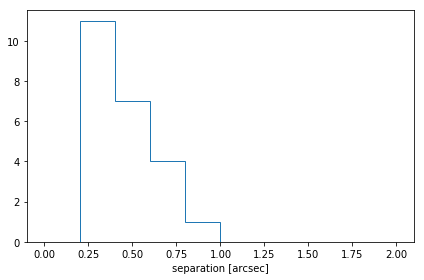

In [21]:
plt.hist(d2d_sdss.arcsec, histtype='step', range=(0,2))
plt.xlabel('separation [arcsec]')
plt.tight_layout()

Ok, they're all within an arcsecond that's promising.  But are we sure it's not just that *anything* has matches within an arcescond?  Lets check by comparing to a set of *random* points.

We first create a set of uniformly random points (with size matching `coo_twomass`) that cover the same range of RA/Decs that are in `coo_sdss`.

In [22]:
ras_sim = np.random.rand(len(coo_twomass))*coo_sdss.ra.ptp() + coo_sdss.ra.min()
decs_sim = np.random.rand(len(coo_twomass))*coo_sdss.dec.ptp() + coo_sdss.dec.min()
ras_sim, decs_sim

(<Angle [ 9.62023036,  9.48788578,  9.81102637,  9.95309008,  9.62845954,
          9.63760424,  9.72784987,  9.75454434, 10.13987665,  9.52505025,
          9.48833   , 10.12915879,  9.72381316,  9.65222813,  9.70268949,
          9.5468509 ,  9.77306937, 10.04356351,  9.81655347,  9.99825206,
         10.04132856,  9.83958983,  9.97319958] deg>,
 <Angle [0.90272302, 1.16384871, 0.89463432, 0.69198843, 0.75443807,
         1.02115967, 0.83684385, 1.02282561, 0.67576403, 1.08931145,
         0.94360007, 0.94360133, 1.17125633, 0.89803461, 0.76006813,
         1.08710447, 0.95649651, 0.74379042, 0.87591993, 1.08659301,
         0.57835151, 1.18843336, 0.66782754] deg>)

Now we create a `SkyCoord` from these points and match it to `coo_sdss` just like we did above for 2MASS.

Note that we do not need to explicitly specify units for `ras_sim` and `decs_sim`, because they already are unitful `Angle` objects because they were created from `coo_sdss.ra`/`coo_sdss.dec`.

In [23]:
coo_simulated = SkyCoord(ras_sim, decs_sim)  
idx_sim, d2d_sim, d3d_sim = coo_simulated.match_to_catalog_sky(coo_sdss)

Now lets plot up the histogram of separations from our simulated catalog so we can compare to the above results from the *real* catalog.

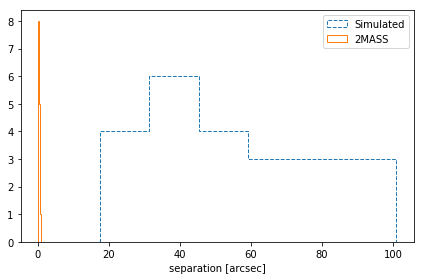

In [24]:
plt.hist(d2d_sim.arcsec, bins='auto', histtype='step', label='Simulated', linestyle='dashed')
plt.hist(d2d_sdss.arcsec, bins='auto', histtype='step', label='2MASS')
plt.xlabel('separation [arcsec]')
plt.legend(loc=0)
plt.tight_layout()

Alright, great - looks like randomly placed sources should be more like an arc*minute* away, so we can probably trust that our earlier matches which were within an arc*second* are valid.  So with that in mind, we can start computing things like colors that combine the SDSS and 2MASS photometry.

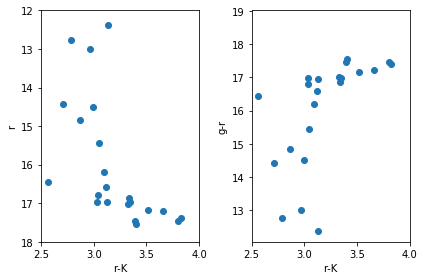

In [25]:
rmag = sdss['r'][idx_sdss]
grcolor = sdss['g'][idx_sdss] - rmag
rKcolor = rmag - twomass['k_m_ext']

plt.subplot(1, 2, 1)
plt.scatter(rKcolor, rmag)
plt.xlabel('r-K')
plt.ylabel('r')
plt.xlim(2.5, 4)
plt.ylim(18, 12) #mags go backwards!

plt.subplot(1, 2, 2)
plt.scatter(rKcolor, rmag)
plt.xlabel('r-K')
plt.ylabel('g-r')
plt.xlim(2.5, 4)

plt.tight_layout()

For more on what matching options are available, check out the [separation and matching section of the astropy documentation](http://astropy.readthedocs.org/en/latest/coordinates/matchsep.html).  Or for more on what you can do with `SkyCoord`, see [its API documentation](http://astropy.readthedocs.org/en/latest/api/astropy.coordinates.SkyCoord.html).

### Exercises

Check that the ``d2d_sdss`` variable matches the on-sky separations you get from comaparing the matched ``coo_sdss`` entries to ``coo_twomass``.  

Hint: You'll likely find the ``SkyCoord.separation()`` method useful here.

Compute the *physical* separation between two (or more) objects in the catalogs.  You'll need line-of-sight distances, so a reasonable guess might be the distance to HCG 7, which is about 55 Mpc. 

Hint: you'll want to create new `SkyCoord` objects, but with ``distance`` attributes.  There's also a `SkyCoord` method that should do the rest of the work, but you'll have to poke around to figure out what it is.

## Transforming between coordinate systems and planning observations

Now lets say something excites you about one of the objects in this catalog, and you want to know if and when you might go about observing it.  `astropy.coordinates` provides tools to enable this, as well.

### Introducting frame transformations

To understand the code in this section, it may help to read over the [overview of the astropy coordinates scheme](http://astropy.readthedocs.org/en/latest/coordinates/index.html#overview-of-astropy-coordinates-concepts).  The key bit to understand is that all coordinates in astropy are in particular "frames", and we can transform between a specific `SkyCoord` object from one frame to another.  For example, we can transform our previously-defined center of HCG7 from ICRS to Galactic coordinates:

In [26]:
hcg7_center.galactic

<SkyCoord (Galactic): (l, b) in deg
    (116.47556813, -61.83099472)>

The above is actually a special "quick-access" form which internally does the same as what's in the cell below: uses the `transform_to()` method to convert from one frame to another.

In [27]:
from astropy.coordinates import Galactic
hcg7_center.transform_to(Galactic())

<SkyCoord (Galactic): (l, b) in deg
    (116.47556813, -61.83099472)>

Note that changing frames also changes some of the attributes of the object, but usually in a way that makes sense:

In [28]:
hcg7_center.galactic.ra  # should fail because galactic coordinates are l/b not RA/Dec

AttributeError: 'SkyCoord' object has no attribute 'ra'

In [29]:
hcg7_center.galactic.b

<Latitude -61.83099472 deg>

### Using frame transformations to get to AltAz

To actually do anything with observability we need to convert to a frame local to an on-earth observer.  By far the most common choice is horizontal coordinates, or "AltAz" coordinates.  We first need to specify both where and when we want to try to observe.

In [30]:
from astropy.coordinates import EarthLocation
from astropy.time import Time

observing_location = EarthLocation(lat='31d57.5m', lon='-111d35.8m', height=2096*u.m)  # Kitt Peak, Arizona
# If you're using astropy v1.1 or later, you can replace the above with this:
#observing_location = EarthLocation.of_site('Kitt Peak')

observing_time = Time('2010-12-21 1:00')  # 1am UTC=6pm AZ mountain time

Now we use these to create an `AltAz` frame object.  Note that this frame has some other information about the atmosphere, which can be used to correct for atmospheric refraction.  Here we leave that alone, because the default is to ignore this effect (by setting the pressure to 0).

In [31]:
from astropy.coordinates import AltAz

aa = AltAz(location=observing_location, obstime=observing_time)
aa

<AltAz Frame (obstime=2010-12-21 01:00:00.000, location=(-1994310.09211632, -5037908.606337594, 3357621.752122168) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0, obswl=1.0 micron)>

Now we can just transform our ICRS `SkyCoord` to `AltAz` to get the location in the sky over Kitt Peak at the requested time.

In [32]:
hcg7_center.transform_to(aa)

<SkyCoord (AltAz: obstime=2010-12-21 01:00:00.000, location=(-1994310.09211632, -5037908.606337594, 3357621.752122168) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0, obswl=1.0 micron): (az, alt) in deg
    (149.19392036, 55.0624736)>

Alright, it's up at 6pm, but that's pretty early to be observing.  We could just try various times one at a time to see if the airmass is at a darker time, but we can do better: lets try to create an airmass plot.

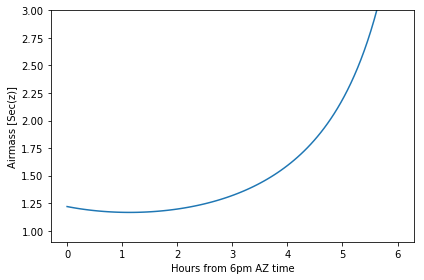

In [33]:
# this gives a Time object with an *array* of times
delta_hours = np.linspace(0, 6, 100)*u.hour
full_night_times = observing_time + delta_hours
full_night_aa_frames = AltAz(location=observing_location, obstime=full_night_times)
full_night_aa_coos = hcg7_center.transform_to(full_night_aa_frames)

plt.plot(delta_hours, full_night_aa_coos.secz)
plt.xlabel('Hours from 6pm AZ time')
plt.ylabel('Airmass [Sec(z)]')
plt.ylim(0.9,3)
plt.tight_layout()

Great!  Looks like it's at the lowest airmass in another hour or so (7pm).  But might that might still be twilight... When should we start observing for proper dark skies?  Fortunately, astropy provides a ``get_sun`` function that can be used to check this.  Lets use it to check if we're in 18-degree twilight or not.

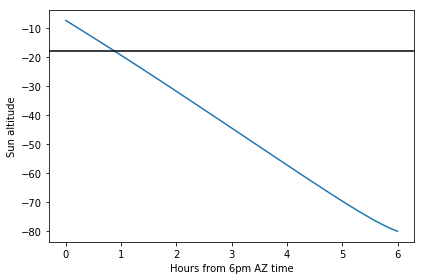

In [34]:
from astropy.coordinates import get_sun

full_night_sun_coos = get_sun(full_night_times).transform_to(full_night_aa_frames)
plt.plot(delta_hours, full_night_sun_coos.alt.deg)
plt.axhline(-18, color='k')
plt.xlabel('Hours from 6pm AZ time')
plt.ylabel('Sun altitude')
plt.tight_layout()

Looks like it's just below 18 degrees at 7, so you should be good to go!

### Exercises

Try to actually compute to some arbitrary precision (rather than eye-balling on a plot) when 18 degree twilight or sunrise/sunset hits on that night.

Try converting the HCG7 coordinates to an equatorial frame at some other equinox a while in the past (like J2000).  Do you see the precession of the equinoxes?

Hint: To see a diagram of the supported frames look [here](http://docs.astropy.org/en/stable/coordinates/#module-astropy.coordinates).  One of those will do what you need if you give it the right frame attributes.

## Wrap-up

For lots more documentation on the many other features of `astropy.coordinates`, check out [its section of the documentation](http://astropy.readthedocs.org/en/latest/coordinates/index.html).

You might also be interested in [the astroplan affiliated package](http://astroplan.readthedocs.org/), which uses the `astropy.coordinates` to do more advanced versions of the tasks in the last section of this tutorial.